# Урок 2. Feed-forward neural network

Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from random import shuffle
from tools import paralell_execution, ar_split_eq_cpu
import copy


def plot_image(prediction_array, true_label, img):

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.permute(1, 2, 0))

    predicted_label = torch.argmax(prediction_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% \n({})".format(classes[predicted_label],
                                100*torch.max(prediction_array),
                                classes[true_label]),
                                color=color)

def plot_value_array(prediction_array, true_label):

    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks([])
    plot = plt.bar(range(len(classes)), prediction_array.detach().numpy())
    plt.ylim([0, 1])
    predicted_label = torch.argmax(prediction_array)

    plot[predicted_label].set_color('red')
    plot[true_label].set_color('blue')



torch.random.manual_seed(42)
download = True
classes = []
with open('data/cifar-10-batches-py/batches.meta', 'rb') as f:
    classes = pickle.load(f)['label_names']


In [2]:
class Net(nn.Module):
    def __init__(self, param:dict):
        self.input_dim = param['input_dim']
        self.hidden_dim = param['hidden_dim']
        self.output_dim = param['output_dim']
        self.layers_cnt = param['layers_cnt']
        super().__init__()
        
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        if self.layers_cnt>2:
            self.fc3 = nn.Linear(self.hidden_dim, self.hidden_dim)
            torch.nn.init.xavier_uniform_(self.fc3.weight)
        
        self.fc4 = nn.Linear(self.hidden_dim, self.output_dim)
        torch.nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        if self.layers_cnt>2:
            x = self.fc3(x)
            x = F.relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x = F.softmax(x, dim=1)
        return x


In [3]:
# комбинации параметров нейросети 
params = []


for input_dim in [32*32*3]:
    for hidden_dim in [128]: # 128, 256
        for output_dim in [10]:
            for layers_cnt in [3]: # 2, 3
                for lr in [1e-3]: # 1e-3, 5e-3
                    for epochs in [15]: # 15, 25
                        params.append({
                                'input_dim': input_dim, 
                                'hidden_dim': hidden_dim, 
                                'output_dim': output_dim, 
                                'layers_cnt': layers_cnt, 
                                'lr': lr, 
                                'epochs': epochs, 
                              })

shuffle(params)
print(f'Всего комбинаций параметров: {len(params)}')

def train(params):
    ret = []
    for param in params:
    
        download = False
        train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                                     train=True,  
                                                     transform=transforms.ToTensor(), 
                                                     download=download)
        
        test_dataset = torchvision.datasets.CIFAR10(root='data/', 
                                                    train=False, 
                                                    transform=transforms.ToTensor(),
                                                    download=download)
        
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=64, 
                                                   shuffle=True)
        
        test_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=len(test_dataset),
                                                  shuffle=False)
        
        # проверочные данные для оценки точности модели
        test_images, test_labels = None, None
        for i, data in enumerate(test_loader):
            test_images, test_labels = data[0], data[1]
            break
        
        net = Net(param)
        net.train()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=param['lr'])
        
        EPOCHS = 5
        for epoch in range(param['epochs']):
        
            for i, data in enumerate(train_loader):
                inputs, labels = data[0], data[1]
                
                optimizer.zero_grad() # Обнуляем градиент
                # Делаем предсказание
                outputs = net(inputs)
                # Рассчитываем лосс-функцию
                loss = criterion(outputs, labels)
                # Делаем шаг назад по лоссу
                loss.backward()
                # Делаем шаг нашего оптимайзера
                optimizer.step()
                
        net.eval()
        predictions = net.predict(test_images)
        acc = float((torch.argmax(predictions, axis=1) == test_labels).sum() / len(test_labels) * 100)

        ret.append({
            'acc': acc,
            'param': param,
            'net': net
        })
    return ret


args_parallel = []
for param_chunk in ar_split_eq_cpu(params):
    args_parallel.append(param_chunk)

# запускаем процесс параллельных вычислений
res = paralell_execution(func=train,
                         arg=args_parallel,
                         method='multiprocessing')

best_acc = 0 # точность лучшей модели
best_param = {} # параметры лучшей модели
best_net = None # лучшая модель
for chunk in res: # объединяем результаты со всех ядер
    for row in chunk:
        if row['acc'] > best_acc:
            best_acc = row['acc']
            best_param = row['param']
            best_net = row['net']

print(f'Лучшая точность: {round(best_acc, 1)} % при параметрах {best_param}')

Всего комбинаций параметров: 1
Лучшая точность: 49.2 % при параметрах {'input_dim': 3072, 'hidden_dim': 128, 'output_dim': 10, 'layers_cnt': 3, 'lr': 0.001, 'epochs': 15}


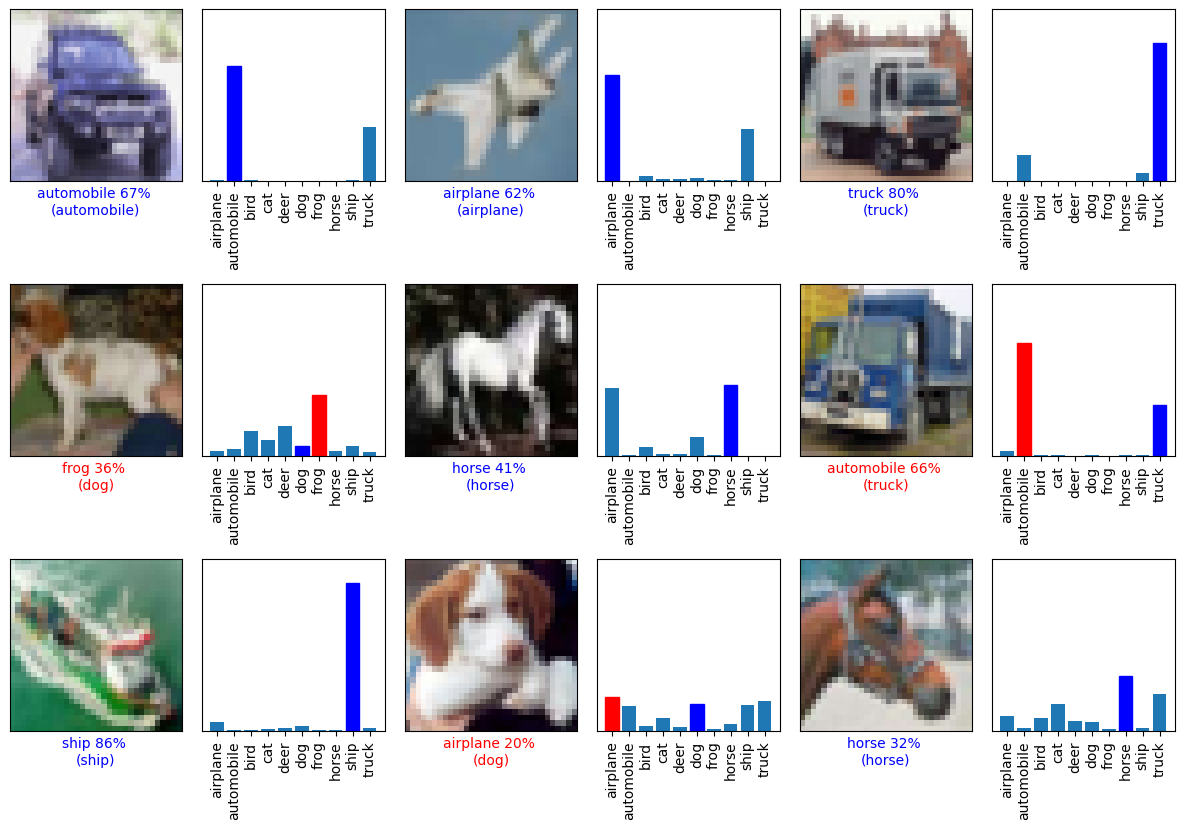

In [4]:
%matplotlib inline

test_dataset = torchvision.datasets.CIFAR10(root='data/', 
                                            train=False, 
                                            transform=transforms.ToTensor(),
                                            download=False)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=len(test_dataset),
                                          shuffle=False)

images, labels = None, None
for i, data in enumerate(test_loader):
    images, labels = data[0], data[1]
    break

net = best_net
net.eval()
predictions = net.predict(images)

num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*1.4*num_rows))
PAGE = 2
for i in range(num_images):
    idx = i + (PAGE-1) * num_images
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(predictions[idx], labels[idx], images[idx])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(predictions[idx], labels[idx])

plt.tight_layout()
plt.show()

Лучшие параметры для модели:{'input_dim': 3072, 'hidden_dim': 128, 'output_dim': 10, 'layers_cnt': 3, 'lr': 0.001, 'epochs': 15}

Функция активации - ReLU

Оптимизатор - Adam
